In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np

crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 72
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-02 18:16:15.010238: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 18:16:15.030634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 18:16:15.030651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 18:16:15.031200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 18:16:15.034786: I tensorflow/core/platform/cpu_feature_guar

8031
Train shape:  (8031, 164, 225) (8031, 60) Test Shape:  (1276, 164, 225) (1276, 60)


In [5]:

import tensorflow as tf
import gc

# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    # early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size,validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    tf.keras.backend.clear_session()
    del model
    gc.collect()
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-02 18:16:16.308087: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-02 18:16:16.308109: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-02 18:16:16.308112: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-02 18:16:16.308201: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-02 18:16:16.308211: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-02 18:16:16.308212: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704197779.799586  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/101 [============================>.] - ETA: 0s - loss: 3.9816 - accuracy: 0.0557

W0000 00:00:1704197786.732058  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 9s 69ms/step - loss: 3.9802 - accuracy: 0.0562 - val_loss: 3.7109 - val_accuracy: 0.1082
Epoch 2/200
101/101 [==============================] - 6s 62ms/step - loss: 3.5015 - accuracy: 0.1535 - val_loss: 3.1422 - val_accuracy: 0.3035
Epoch 3/200
101/101 [==============================] - 6s 62ms/step - loss: 3.0792 - accuracy: 0.2372 - val_loss: 2.7155 - val_accuracy: 0.3831
Epoch 4/200
101/101 [==============================] - 6s 63ms/step - loss: 2.7560 - accuracy: 0.3173 - val_loss: 2.4136 - val_accuracy: 0.4664
Epoch 5/200
101/101 [==============================] - 6s 63ms/step - loss: 2.5117 - accuracy: 0.3737 - val_loss: 2.1619 - val_accuracy: 0.5149
Epoch 6/200
101/101 [==============================] - 6s 64ms/step - loss: 2.3165 - accuracy: 0.4068 - val_loss: 1.9654 - val_accuracy: 0.5920
Epoch 7/200
101/101 [==============================] - 6s 64ms/step - loss: 2.1619 - accuracy: 0.4504 - val_loss: 1.8215 - val_accuracy: 0.6418
Epoc

W0000 00:00:1704199082.211594  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9788557213930348
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.591692789968652
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704199086.542099  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/101 [============================>.] - ETA: 0s - loss: 3.8364 - accuracy: 0.0796

W0000 00:00:1704199093.526795  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 9s 70ms/step - loss: 3.8357 - accuracy: 0.0794 - val_loss: 3.4942 - val_accuracy: 0.1656
Epoch 2/200
101/101 [==============================] - 6s 64ms/step - loss: 3.3077 - accuracy: 0.1956 - val_loss: 2.9854 - val_accuracy: 0.3163
Epoch 3/200
101/101 [==============================] - 6s 64ms/step - loss: 2.9086 - accuracy: 0.2813 - val_loss: 2.6089 - val_accuracy: 0.3661
Epoch 4/200
101/101 [==============================] - 6s 64ms/step - loss: 2.6100 - accuracy: 0.3401 - val_loss: 2.2844 - val_accuracy: 0.4807
Epoch 5/200
101/101 [==============================] - 6s 64ms/step - loss: 2.3552 - accuracy: 0.3947 - val_loss: 2.0257 - val_accuracy: 0.5567
Epoch 6/200
101/101 [==============================] - 6s 64ms/step - loss: 2.1771 - accuracy: 0.4437 - val_loss: 1.8193 - val_accuracy: 0.6127
Epoch 7/200
101/101 [==============================] - 6s 64ms/step - loss: 2.0072 - accuracy: 0.4857 - val_loss: 1.6550 - val_accuracy: 0.6239
Epoc

W0000 00:00:1704200384.606200  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 2: 0.9825653798256538
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6010971786833855
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704200389.008469  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/101 [============================>.] - ETA: 0s - loss: 3.9303 - accuracy: 0.0678

W0000 00:00:1704200395.991895  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 9s 70ms/step - loss: 3.9293 - accuracy: 0.0679 - val_loss: 3.6020 - val_accuracy: 0.1320
Epoch 2/200
101/101 [==============================] - 6s 64ms/step - loss: 3.4430 - accuracy: 0.1530 - val_loss: 3.1156 - val_accuracy: 0.2603
Epoch 3/200
101/101 [==============================] - 6s 64ms/step - loss: 3.1029 - accuracy: 0.2165 - val_loss: 2.7704 - val_accuracy: 0.3375
Epoch 4/200
101/101 [==============================] - 6s 64ms/step - loss: 2.8328 - accuracy: 0.2792 - val_loss: 2.5216 - val_accuracy: 0.4072
Epoch 5/200
101/101 [==============================] - 6s 64ms/step - loss: 2.6581 - accuracy: 0.3129 - val_loss: 2.3246 - val_accuracy: 0.4396
Epoch 6/200
101/101 [==============================] - 7s 65ms/step - loss: 2.5036 - accuracy: 0.3503 - val_loss: 2.1689 - val_accuracy: 0.4969
Epoch 7/200
101/101 [==============================] - 6s 64ms/step - loss: 2.3443 - accuracy: 0.3911 - val_loss: 2.0108 - val_accuracy: 0.5455
Epoc

W0000 00:00:1704203750.481165  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 41ms/step
Validation Accuracy Fold 3: 0.9813200498132005
40/40 [==============================] - 2s 42ms/step
Test - Accuracy: 0.6371473354231975
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704203768.722774  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 3.9460 - accuracy: 0.0567

W0000 00:00:1704203789.715465  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 31s 203ms/step - loss: 3.9460 - accuracy: 0.0567 - val_loss: 3.6407 - val_accuracy: 0.1096
Epoch 2/200
101/101 [==============================] - 19s 185ms/step - loss: 3.4387 - accuracy: 0.1558 - val_loss: 3.0537 - val_accuracy: 0.2852
Epoch 3/200
101/101 [==============================] - 18s 178ms/step - loss: 2.9684 - accuracy: 0.2514 - val_loss: 2.6157 - val_accuracy: 0.3910
Epoch 4/200
101/101 [==============================] - 19s 184ms/step - loss: 2.6296 - accuracy: 0.3254 - val_loss: 2.2612 - val_accuracy: 0.4882
Epoch 5/200
101/101 [==============================] - 19s 185ms/step - loss: 2.3598 - accuracy: 0.3893 - val_loss: 1.9569 - val_accuracy: 0.5629
Epoch 6/200
101/101 [==============================] - 18s 180ms/step - loss: 2.1325 - accuracy: 0.4447 - val_loss: 1.7961 - val_accuracy: 0.6015
Epoch 7/200
101/101 [==============================] - 18s 183ms/step - loss: 1.9721 - accuracy: 0.4893 - val_loss: 1.6391 - val_accurac

W0000 00:00:1704207513.805253  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 41ms/step
Validation Accuracy Fold 4: 0.9738480697384807
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.5924764890282131
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704207531.706499  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 3.9726 - accuracy: 0.0562

W0000 00:00:1704207553.311102  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 32s 212ms/step - loss: 3.9726 - accuracy: 0.0562 - val_loss: 3.7572 - val_accuracy: 0.1270
Epoch 2/200
101/101 [==============================] - 18s 182ms/step - loss: 3.4817 - accuracy: 0.1579 - val_loss: 3.1513 - val_accuracy: 0.2740
Epoch 3/200
101/101 [==============================] - 19s 187ms/step - loss: 3.0704 - accuracy: 0.2391 - val_loss: 2.7803 - val_accuracy: 0.3599
Epoch 4/200
101/101 [==============================] - 18s 183ms/step - loss: 2.7817 - accuracy: 0.3066 - val_loss: 2.5100 - val_accuracy: 0.4545
Epoch 5/200
101/101 [==============================] - 19s 185ms/step - loss: 2.5434 - accuracy: 0.3651 - val_loss: 2.2427 - val_accuracy: 0.5143
Epoch 6/200
101/101 [==============================] - 19s 190ms/step - loss: 2.3531 - accuracy: 0.4090 - val_loss: 2.0427 - val_accuracy: 0.5592
Epoch 7/200
101/101 [==============================] - 18s 182ms/step - loss: 2.2195 - accuracy: 0.4391 - val_loss: 1.9067 - val_accurac

W0000 00:00:1704211216.839289  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 42ms/step
Validation Accuracy Fold 5: 0.9701120797011208
40/40 [==============================] - 2s 43ms/step
Test - Accuracy: 0.6324451410658307
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704211235.669086  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 3.9635 - accuracy: 0.0544

W0000 00:00:1704211256.726252  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 31s 207ms/step - loss: 3.9635 - accuracy: 0.0544 - val_loss: 3.7487 - val_accuracy: 0.0822
Epoch 2/200
101/101 [==============================] - 19s 186ms/step - loss: 3.5437 - accuracy: 0.1354 - val_loss: 3.2736 - val_accuracy: 0.2366
Epoch 3/200
101/101 [==============================] - 18s 179ms/step - loss: 3.1272 - accuracy: 0.2211 - val_loss: 2.8805 - val_accuracy: 0.3350
Epoch 4/200
101/101 [==============================] - 19s 187ms/step - loss: 2.8500 - accuracy: 0.2818 - val_loss: 2.6078 - val_accuracy: 0.3973
Epoch 5/200
101/101 [==============================] - 19s 184ms/step - loss: 2.6274 - accuracy: 0.3283 - val_loss: 2.3825 - val_accuracy: 0.4446
Epoch 6/200
101/101 [==============================] - 18s 180ms/step - loss: 2.4385 - accuracy: 0.3654 - val_loss: 2.1943 - val_accuracy: 0.5093
Epoch 7/200
101/101 [==============================] - 19s 189ms/step - loss: 2.2557 - accuracy: 0.4198 - val_loss: 2.0432 - val_accurac

W0000 00:00:1704214956.882741  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 41ms/step
Validation Accuracy Fold 6: 0.9663760896637609
40/40 [==============================] - 2s 43ms/step
Test - Accuracy: 0.6379310344827587
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704214975.839416  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 3.9116 - accuracy: 0.0592

W0000 00:00:1704214996.833586  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 31s 206ms/step - loss: 3.9116 - accuracy: 0.0592 - val_loss: 3.6294 - val_accuracy: 0.1320
Epoch 2/200
101/101 [==============================] - 19s 187ms/step - loss: 3.4468 - accuracy: 0.1565 - val_loss: 3.2707 - val_accuracy: 0.2204
Epoch 3/200
101/101 [==============================] - 19s 185ms/step - loss: 3.1031 - accuracy: 0.2268 - val_loss: 2.9139 - val_accuracy: 0.3101
Epoch 4/200
101/101 [==============================] - 18s 180ms/step - loss: 2.8220 - accuracy: 0.2915 - val_loss: 2.6685 - val_accuracy: 0.4060
Epoch 5/200
101/101 [==============================] - 19s 189ms/step - loss: 2.6224 - accuracy: 0.3428 - val_loss: 2.4119 - val_accuracy: 0.4770
Epoch 6/200
101/101 [==============================] - 18s 178ms/step - loss: 2.4516 - accuracy: 0.3724 - val_loss: 2.2286 - val_accuracy: 0.5143
Epoch 7/200
101/101 [==============================] - 19s 186ms/step - loss: 2.2878 - accuracy: 0.4120 - val_loss: 2.0651 - val_accurac

W0000 00:00:1704218704.192743  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 35ms/step
Validation Accuracy Fold 7: 0.9738480697384807
40/40 [==============================] - 2s 38ms/step
Test - Accuracy: 0.5869905956112853
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704218722.326348  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 4.0015 - accuracy: 0.0445

W0000 00:00:1704218743.843214  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 32s 211ms/step - loss: 4.0015 - accuracy: 0.0445 - val_loss: 3.8001 - val_accuracy: 0.0934
Epoch 2/200
101/101 [==============================] - 19s 188ms/step - loss: 3.6402 - accuracy: 0.1162 - val_loss: 3.3915 - val_accuracy: 0.2030
Epoch 3/200
101/101 [==============================] - 19s 190ms/step - loss: 3.2716 - accuracy: 0.2028 - val_loss: 2.9876 - val_accuracy: 0.3200
Epoch 4/200
101/101 [==============================] - 18s 180ms/step - loss: 2.9548 - accuracy: 0.2667 - val_loss: 2.7000 - val_accuracy: 0.3973
Epoch 5/200
101/101 [==============================] - 19s 185ms/step - loss: 2.6912 - accuracy: 0.3293 - val_loss: 2.4016 - val_accuracy: 0.4732
Epoch 6/200
101/101 [==============================] - 19s 185ms/step - loss: 2.4934 - accuracy: 0.3693 - val_loss: 2.1518 - val_accuracy: 0.5255
Epoch 7/200
101/101 [==============================] - 18s 181ms/step - loss: 2.3389 - accuracy: 0.4036 - val_loss: 1.9780 - val_accurac

W0000 00:00:1704222410.123553  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 43ms/step
Validation Accuracy Fold 8: 0.9775840597758406
40/40 [==============================] - 2s 45ms/step
Test - Accuracy: 0.6136363636363636
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704222429.631004  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 3.9611 - accuracy: 0.0552

W0000 00:00:1704222450.670078  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 31s 208ms/step - loss: 3.9611 - accuracy: 0.0552 - val_loss: 3.6512 - val_accuracy: 0.0909
Epoch 2/200
101/101 [==============================] - 19s 189ms/step - loss: 3.4635 - accuracy: 0.1482 - val_loss: 3.0718 - val_accuracy: 0.2553
Epoch 3/200
101/101 [==============================] - 19s 187ms/step - loss: 3.0226 - accuracy: 0.2429 - val_loss: 2.7101 - val_accuracy: 0.3773
Epoch 4/200
101/101 [==============================] - 19s 193ms/step - loss: 2.7382 - accuracy: 0.2983 - val_loss: 2.3944 - val_accuracy: 0.4533
Epoch 5/200
101/101 [==============================] - 19s 186ms/step - loss: 2.4792 - accuracy: 0.3651 - val_loss: 2.1923 - val_accuracy: 0.5106
Epoch 6/200
101/101 [==============================] - 19s 186ms/step - loss: 2.3039 - accuracy: 0.4040 - val_loss: 1.9445 - val_accuracy: 0.5729
Epoch 7/200
101/101 [==============================] - 19s 192ms/step - loss: 2.1440 - accuracy: 0.4458 - val_loss: 1.7881 - val_accurac

W0000 00:00:1704226195.301762  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 43ms/step
Validation Accuracy Fold 9: 0.9800747198007472
40/40 [==============================] - 2s 44ms/step
Test - Accuracy: 0.5995297805642633
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704226215.546440  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 3.9220 - accuracy: 0.0576

W0000 00:00:1704226236.814079  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 32s 209ms/step - loss: 3.9220 - accuracy: 0.0576 - val_loss: 3.5825 - val_accuracy: 0.1644
Epoch 2/200
101/101 [==============================] - 19s 188ms/step - loss: 3.4094 - accuracy: 0.1617 - val_loss: 3.0915 - val_accuracy: 0.2951
Epoch 3/200
101/101 [==============================] - 18s 181ms/step - loss: 3.0302 - accuracy: 0.2420 - val_loss: 2.7055 - val_accuracy: 0.4234
Epoch 4/200
101/101 [==============================] - 19s 190ms/step - loss: 2.7622 - accuracy: 0.3081 - val_loss: 2.4633 - val_accuracy: 0.4732
Epoch 5/200
101/101 [==============================] - 19s 186ms/step - loss: 2.5113 - accuracy: 0.3776 - val_loss: 2.2165 - val_accuracy: 0.5604
Epoch 6/200
101/101 [==============================] - 19s 188ms/step - loss: 2.3282 - accuracy: 0.4177 - val_loss: 2.0200 - val_accuracy: 0.5666
Epoch 7/200
101/101 [==============================] - 19s 186ms/step - loss: 2.1887 - accuracy: 0.4476 - val_loss: 1.8909 - val_accurac

W0000 00:00:1704229917.452582  734528 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 3s 44ms/step
Validation Accuracy Fold 10: 0.9763387297633873
40/40 [==============================] - 2s 42ms/step
Test - Accuracy: 0.6261755485893417
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.591692789968652, 0.6010971786833855, 0.6371473354231975, 0.5924764890282131, 0.6324451410658307, 0.6379310344827587, 0.5869905956112853, 0.6136363636363636, 0.5995297805642633, 0.6261755485893417]
0.6119122257053292
[0.9788557213930348, 0.9825653798256538, 0.9813200498132005, 0.9738480697384807, 0.9701120797011208, 0.9663760896637609, 0.9738480697384807, 0.9775840597758406, 0.9800747198007472, 0.9763387297633873]
0.9760922969213708


test accuracies:  [0.591692789968652, 0.6010971786833855, 0.6371473354231975, 0.5924764890282131, 0.6324451410658307, 0.6379310344827587, 0.5869905956112853, 0.6136363636363636, 0.5995297805642633, 0.6261755485893417] 5
validation accuracies:  [0.9788557213930348, 0.9825653798256538, 0.9813200498132005, 0.9738480697384807, 0.9701120797011208, 0.9663760896637609, 0.9738480697384807, 0.9775840597758406, 0.9800747198007472, 0.9763387297633873]
60


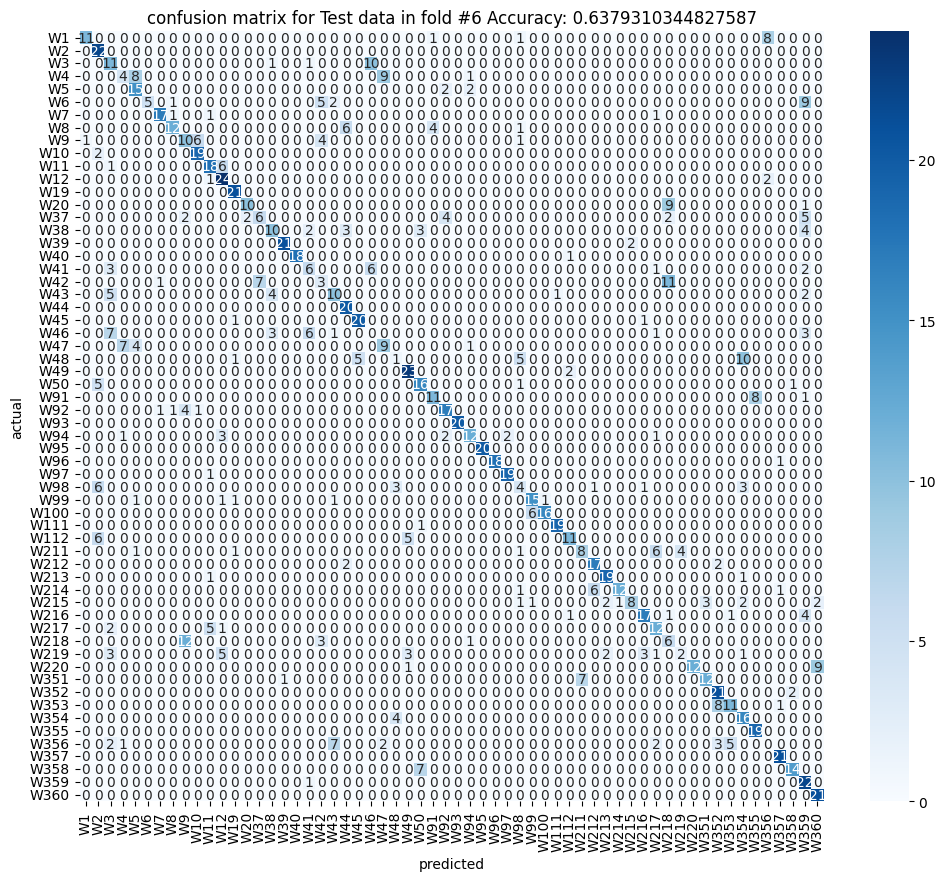

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
